# Borzoi Variant Effect Prediction on Gene Expression
This notebook performs in silico mutagenesis to predict the effect of SNPs on gene expression.
**Features:**
- Configurable task filtering (assay, description, name keywords)
- Both TSS-centered and SNP-centered prediction strategies
- Averaging across all 4 Borzoi replicates
- Comprehensive validation checks
- Z-score normalization of effects


## 1. Setup and Imports


In [1]:

# Package dependencies
import os
import sys
from pathlib import Path

# Determine project root relative to this notebook
# This notebook is in vignettes/, so root is one level up
NOTEBOOK_DIR = Path(os.getcwd()).resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent

# Add project root to sys.path to ensure utils can be imported
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print(f"Notebook directory: {NOTEBOOK_DIR}")
print(f"Project root: {PROJECT_ROOT}")

os.environ['GENOMEPY_CACHE_DIR'] = '/storage/work/mgc5166/Annotations/eQTL_annotations_for_susine/data/genomes'
os.environ['WANDB_CACHE_DIR'] = '/storage/work/mgc5166/Annotations/eQTL_annotations_for_susine/wandb'

from typing import Dict, List, Optional
import grelu.resources
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import warnings
from tqdm import tqdm

import genomepy
print(genomepy.utils.get_genomes_dir())

from utils.data_ingestion import (
    download_gtf_if_needed,
    get_gene_info,
    load_gene_annotations_for_gene,
    load_vcf,
)
from utils.genome import (
    create_centered_window,
    ensure_fasta_shortcut,
    get_output_bins_for_interval,
    validate_bins_in_output,
    get_window_sequence,
    get_all_bin_indices,
)
from utils.prediction import (
    filter_tasks,
    run_full_analysis,
    analyze_variant,
    predict_on_sequence,
    aggregate_predictions,
)
warnings.filterwarnings('ignore')
print("Imports complete.")


Notebook directory: /storage/work/mgc5166/Annotations/eQTL_annotations_for_susine/vignettes
Project root: /storage/work/mgc5166/Annotations/eQTL_annotations_for_susine
/storage/work/mgc5166/Annotations/eQTL_annotations_for_susine/data/genomes
Imports complete.


## 2. Configuration
Set your parameters here:


In [2]:

# =============================================================================

# USER CONFIGURATION

# =============================================================================

# Gene of interest
GENE_NAME = "CBX8"  # Change this to your gene of interest

# Paths and caching
# All paths are now relative to PROJECT_ROOT
GTF_CACHE_DIR = PROJECT_ROOT / "data/gtf_cache"
GTF_SHORTCUT_DIR = PROJECT_ROOT / "data/gtf_shortcuts"
FASTA_SHORTCUT_DIR = PROJECT_ROOT / "data/fasta_shortcuts"
OUTPUT_DIR = PROJECT_ROOT / "output"

# VCF file path (set to your VCF file)
VCF_FILE = OUTPUT_DIR / f"{GENE_NAME}_variants.vcf"

FASTA_SHORTCUT_RADIUS = 1_000_000  # +/- bp around TSS to cache

# Reference genome tag for grelu
REFERENCE_GENOME = "hg38"

# Prediction Strategy
# Set to True to ONLY run TSS-centered predictions (faster, saves compute)
# Set to False to run both TSS-centered and SNP-centered predictions (more comprehensive)
TSS_CENTERED_ONLY = True

# Task filtering (case-insensitive, uses 'contains')

# Set to None to skip that filter
TASK_FILTER = {
    "assay": "rna",           # e.g., "rna", "cage", "atac"
    "description": "lung",    # e.g., "lung", "brain", "liver"
    "name": "gtex",           # e.g., "gtex", "encode"
}

# Aggregation method for predictions across tasks and bins
TASK_AGGFUNC = "mean"    # "mean" or "sum"
LENGTH_AGGFUNC = "sum"   # "mean" or "sum" (sum is typical for gene expression)

# Model replicates to use (0, 1, 2, 3 available)
MODEL_REPLICATES = [0, 1, 2, 3]

# Set device to GPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Device name: {torch.cuda.get_device_name(0)}")


CUDA available: True
Device count: 1
Device name: Tesla P100-PCIE-12GB


## 3. Download/Load GTF Annotations


In [3]:

# Download and load GTF (cached if already present)
gtf_gene_shortcut = GTF_SHORTCUT_DIR / f"{GENE_NAME}_gene_annotations.csv"
gtf_exon_shortcut = GTF_SHORTCUT_DIR / f"{GENE_NAME}_exon_annotations.csv"
gtf_needed = not (gtf_gene_shortcut.exists() and gtf_exon_shortcut.exists())
if gtf_needed:
    gtf_path = download_gtf_if_needed(GTF_CACHE_DIR, genome=REFERENCE_GENOME)
else:

    # Path is unused when shortcuts already exist but kept for clarity
    gtf_path = GTF_CACHE_DIR / f"{REFERENCE_GENOME}_gencode.gtf.gz"

# Prefer a gene-specific shortcut to avoid reparsing the full file
genes_df, exons_df, used_gtf_shortcut = load_gene_annotations_for_gene(
    gtf_path,
    GENE_NAME,
    GTF_SHORTCUT_DIR,
)

# Extract gene metadata and exon coordinates
gene_info = get_gene_info(GENE_NAME, genes_df, exons_df)
print(f"Gene: {gene_info['gene_name']}")
print(f"  Location: {gene_info['chrom']}:{gene_info['start']}-{gene_info['end']}")
print(f"  Strand: {gene_info['strand']}")
print(f"  TSS: {gene_info['tss']}")
print(f"  Exons loaded: {len(gene_info['exons'])}")
print(f"  Annotations source: {'shortcut' if used_gtf_shortcut else 'full GTF parse'}")


Loading cached annotations for CBX8 from /storage/work/mgc5166/Annotations/eQTL_annotations_for_susine/data/gtf_shortcuts
Gene: CBX8
  Location: chr17:79792131-79801683
  Strand: -
  TSS: 79801682
  Exons loaded: 11
  Annotations source: shortcut


In [4]:

# Cache a reference FASTA window around the TSS for faster reruns
FASTA_SHORTCUT_META = ensure_fasta_shortcut(
    chrom=gene_info["chrom"],
    tss=gene_info["tss"],
    gene_name=GENE_NAME,
    shortcut_dir=FASTA_SHORTCUT_DIR,
    genome=REFERENCE_GENOME,
    flank_radius=FASTA_SHORTCUT_RADIUS,
)
print(
    f"FASTA shortcut span: {FASTA_SHORTCUT_META['chrom']}:{FASTA_SHORTCUT_META['start']}-"
    f"{FASTA_SHORTCUT_META['end']} (radius {FASTA_SHORTCUT_META['radius']} bp)"
)
gene_info['exons'].head()


Using cached FASTA shortcut for CBX8: /storage/work/mgc5166/Annotations/eQTL_annotations_for_susine/data/fasta_shortcuts/CBX8_region_seq.fasta
FASTA shortcut span: chr17:78801682-80801682 (radius 1000000 bp)


,chrom,start,end
0,chr17,79796929,79797077
1,chr17,79796496,79796540
2,chr17,79796249,79796315
3,chr17,79796056,79796123
4,chr17,79792131,79795558


## 4. Load Borzoi Models


In [5]:
def load_borzoi_replicate(rep: int):
    """Load a single Borzoi replicate model."""
    print(f"Loading Borzoi human_rep{rep}...")
    model = grelu.resources.load_model(
        project="borzoi",
        model_name=f"human_rep{rep}",
    )
    return model

# Load all replicates
models = {}
for rep in MODEL_REPLICATES:
    models[rep] = load_borzoi_replicate(rep)

# Use first model for parameters
model = models[MODEL_REPLICATES[0]]
print(f"\nLoaded {len(models)} model replicates")

wandb: WARNING The anonymous parameter to wandb.login() has no effect and will be removed in future versions.


Loading Borzoi human_rep0...


wandb: Currently logged in as: mgc5166 (mgc5166-penn-state) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Serializing object of type list that is 333648 bytes
wandb: WARNING Serializing object of type list that is 333648 bytes
wandb: WARNING Serializing object of type list that is 333648 bytes
wandb: Downloading large artifact 'human_rep0:latest', 711.80MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:01.5 (464.3MB/s)


Loading Borzoi human_rep1...


wandb: WARNING Serializing object of type list that is 333648 bytes
wandb: WARNING Serializing object of type list that is 333648 bytes
wandb: WARNING Serializing object of type list that is 333648 bytes
wandb: Downloading large artifact 'human_rep1:latest', 711.80MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:00.7 (1057.7MB/s)


Loading Borzoi human_rep2...


wandb: WARNING Serializing object of type list that is 333648 bytes
wandb: WARNING Serializing object of type list that is 333648 bytes
wandb: WARNING Serializing object of type list that is 333648 bytes
wandb: Downloading large artifact 'human_rep2:latest', 711.80MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:00.6 (1099.0MB/s)


Loading Borzoi human_rep3...


wandb: WARNING Serializing object of type list that is 333648 bytes
wandb: WARNING Serializing object of type list that is 333648 bytes
wandb: WARNING Serializing object of type list that is 333648 bytes
wandb: Downloading large artifact 'human_rep3:latest', 711.80MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:00.7 (1020.8MB/s)



Loaded 4 model replicates


In [6]:

# Display model parameters
print("Model data parameters:")
for key in model.data_params['train'].keys():
    if key != "intervals":
        print(f"  {key}: {model.data_params['train'][key]}")

# Key parameters
SEQ_LEN = model.data_params["train"]["seq_len"]  # 524288
LABEL_LEN = model.data_params["train"]["label_len"]  # 196608
BIN_SIZE = model.data_params["train"]["bin_size"]  # 32
CROP_LEN = model.model_params.get("crop_len", 0)  # Cropped bins on each side

# Calculate the editable region (input positions that affect output)
CROP_BP = CROP_LEN * BIN_SIZE
EDITABLE_START = CROP_BP  # First position in input that produces output
EDITABLE_END = SEQ_LEN - CROP_BP  # Last position
print(f"\nKey dimensions:")
print(f"  Input sequence length: {SEQ_LEN:,} bp")
print(f"  Output length: {LABEL_LEN:,} bp")
print(f"  Bin size: {BIN_SIZE} bp")
print(f"  Crop length: {CROP_LEN} bins ({CROP_BP:,} bp)")
print(f"  Editable region: {EDITABLE_START:,} - {EDITABLE_END:,} ({EDITABLE_END - EDITABLE_START:,} bp)")


Model data parameters:
  seq_len: 524288
  label_len: 196608
  genome: hg38
  bin_size: 32

Key dimensions:
  Input sequence length: 524,288 bp
  Output length: 196,608 bp
  Bin size: 32 bp
  Crop length: 5120 bins (163,840 bp)
  Editable region: 163,840 - 360,448 (196,608 bp)


## 5. Filter Tasks


In [7]:
filtered_tasks, task_indices = filter_tasks(
    model,
    assay=TASK_FILTER.get("assay"),
    description=TASK_FILTER.get("description"),
    name=TASK_FILTER.get("name"),
)
print(f"Filtered to {len(task_indices)} tasks")
print(f"\nSample of filtered tasks:")
filtered_tasks.head(10)


Filtered to 3 tasks

Sample of filtered tasks:


,name,file,clip,clip_soft,scale,sum_stat,strand_pair,description,assay,sample
7566,GTEX-1399S-1726-SM-5L3DI.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.01,sum_sqrt,7566,RNA:lung,RNA,lung
7567,GTEX-14AS3-0926-SM-5TDD6.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.01,sum_sqrt,7567,RNA:lung,RNA,lung
7568,GTEX-14JG1-0926-SM-5YY8W.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.01,sum_sqrt,7568,RNA:lung,RNA,lung


In [8]:

# Validation: ensure we have tasks
if len(task_indices) == 0:
    raise ValueError(
        f"No tasks match the filter criteria: {TASK_FILTER}\n"
        "Please adjust TASK_FILTER in the configuration cell."
    )
print(f"Found {len(task_indices)} matching tasks")


Found 3 matching tasks


## 6. Load and Validate VCF


In [9]:

# Load VCF

# For demo, create a synthetic VCF if file doesn't exist
if not VCF_FILE.exists():
    print(f"VCF file not found: {VCF_FILE}")
    print("Creating synthetic demo variants around the gene TSS...")
    np.random.seed(42)
    n_variants = 20
    demo_vcf = pd.DataFrame({
        'chrom': [gene_info['chrom']] * n_variants,
        'pos': gene_info['tss'] + np.random.randint(-100000, 100000, n_variants),
        'rsID': [f'rs{i}' for i in range(n_variants)],
        'ref': np.random.choice(['A', 'C', 'G', 'T'], n_variants),
        'alt': np.random.choice(['A', 'C', 'G', 'T'], n_variants),
    })
    for i in range(len(demo_vcf)):
        while demo_vcf.loc[i, 'ref'] == demo_vcf.loc[i, 'alt']:
            demo_vcf.loc[i, 'alt'] = np.random.choice(['A', 'C', 'G', 'T'])
    demo_vcf['pos_0based'] = demo_vcf['pos'] - 1
    variants_df = demo_vcf
else:
    variants_df = load_vcf(VCF_FILE)
print(f"\nLoaded {len(variants_df)} variants")
variants_df.head()


Filtered 148 non-SNP variants, 2110 SNPs remaining

Loaded 2110 variants


,chrom,pos,rsID,ref,alt,QUAL,FILTER,INFO,pos_0based
0,chr17,79540699,chr17_79540699_G_T_b38,G,T,.,PASS,.,79540698
1,chr17,79540864,chr17_79540864_C_G_b38,C,G,.,PASS,.,79540863
2,chr17,79541188,chr17_79541188_C_T_b38,C,T,.,PASS,.,79541187
3,chr17,79541336,chr17_79541336_A_G_b38,A,G,.,PASS,.,79541335
4,chr17,79541515,chr17_79541515_C_G_b38,C,G,.,PASS,.,79541514


## 7. Validation Functions and Window Calculations


In [10]:

# Calculate number of output bins
N_OUTPUT_BINS = LABEL_LEN // BIN_SIZE
print(f"Number of output bins: {N_OUTPUT_BINS}")


Number of output bins: 6144


In [11]:

# Create TSS-centered window for gene bin calculations
tss_window_start, _ = create_centered_window(gene_info['tss'], SEQ_LEN)
print(f"TSS-centered window start: {tss_window_start:,}")

TSS-centered window start: 79,539,538


In [12]:

# Get gene bins for TSS-centered window
gene_exon_bins_tss = get_output_bins_for_interval(
    model,
    gene_info['exons'],
    tss_window_start
)
print("Gene Exon Bins (TSS-centered window):")
print(gene_exon_bins_tss.head())

# Validate bins are in output
is_valid, msg = validate_bins_in_output(gene_exon_bins_tss, N_OUTPUT_BINS)
print(f"\nValidation: {msg}")
if is_valid:
    print("All gene bins are within output field")
else:
    print(f"WARNING: {msg}")


Gene Exon Bins (TSS-centered window):
   start   end
0   2923  2929
1   2909  2912
2   2902  2905
3   2896  2899
4   2773  2881

Validation: All bins valid (range: 2773 - 3073, output size: 6144)
All gene bins are within output field


## 8. Main Analysis: Variant Effect Prediction


In [13]:

# Pre-calculate TSS reference predictions to save compute
print("Pre-calculating TSS reference predictions...")

# 1. Get TSS window sequence
tss_window_start, tss_window_end = create_centered_window(gene_info['tss'], SEQ_LEN)
ref_seq_tss, _ = get_window_sequence(
    gene_info['chrom'],
    tss_window_start,
    tss_window_end,
    genome=REFERENCE_GENOME,
    fasta_meta=FASTA_SHORTCUT_META,
)

# 2. Get bin indices
all_bins = get_all_bin_indices(gene_exon_bins_tss)
bin_indices_tss = [b for b in all_bins if 0 <= b < N_OUTPUT_BINS]

# 3. Run predictions for each model
tss_ref_preds = []
for i, (_, model) in enumerate(models.items()):
    print(f"  Running reference prediction for model {i}...")
    ref_pred = predict_on_sequence(model, ref_seq_tss, device=DEVICE)
    ref_agg = aggregate_predictions(
        ref_pred,
        task_indices,
        bin_indices_tss,
        task_agg=TASK_AGGFUNC,
        length_agg=LENGTH_AGGFUNC,
    )
    tss_ref_preds.append(ref_agg)

print("TSS reference predictions pre-calculated.")


Pre-calculating TSS reference predictions...
  Running reference prediction for model 0...
  Running reference prediction for model 1...
  Running reference prediction for model 2...
  Running reference prediction for model 3...
TSS reference predictions pre-calculated.


In [14]:

print(f"Running analysis on {len(variants_df)} variants...")

print(f"Using {len(models)} model replicates")
if TSS_CENTERED_ONLY:
    print("Strategy: TSS-centered ONLY")
    print(f"(Total of {len(models)} predictions per allele per variant)\n")
else:
    print("Strategy: Both TSS-centered and SNP-centered")
    print(f"(Total of {len(models) * 2} predictions per allele per variant)\n")

# Modified run_full_analysis to support TSS_CENTERED_ONLY flag
# We'll define a wrapper or modify the loop here since we can't easily change utils/prediction.py from here
# But actually, we can just iterate here and call analyze_variant directly, similar to run_full_analysis

results = []

for _, row in tqdm(variants_df.iterrows(), total=len(variants_df), desc="Analyzing variants"):
    # 1. TSS-Centered Prediction
    tss_result = analyze_variant(
        row,
        models,
        gene_info,
        task_indices,
        seq_len=SEQ_LEN,
        editable_start=EDITABLE_START,
        editable_end=EDITABLE_END,
        n_output_bins=N_OUTPUT_BINS,
        task_agg=TASK_AGGFUNC,
        length_agg=LENGTH_AGGFUNC,
        device=DEVICE,
        genome=REFERENCE_GENOME,
        centering="tss",
        fasta_meta=FASTA_SHORTCUT_META,
        precomputed_ref_preds=tss_ref_preds,
    )

    # 2. SNP-Centered Prediction (Optional)
    if not TSS_CENTERED_ONLY:
        snp_result = analyze_variant(
            row,
            models,
            gene_info,
            task_indices,
            seq_len=SEQ_LEN,
            editable_start=EDITABLE_START,
            editable_end=EDITABLE_END,
            n_output_bins=N_OUTPUT_BINS,
            task_agg=TASK_AGGFUNC,
            length_agg=LENGTH_AGGFUNC,
            device=DEVICE,
            genome=REFERENCE_GENOME,
            centering="snp",
            fasta_meta=FASTA_SHORTCUT_META,
        )
    else:
        snp_result = {"status": "skipped", "reason": "tss_only_mode"}

    record = {
        "rsID": row["rsID"],
        "chrom": row["chrom"],
        "position": row["pos"],
        "ref_allele": row["ref"],
        "alt_allele": row["alt"],
        "relative_to_tss": row["pos"] - gene_info["tss"],
    }

    # Process TSS results
    record["tss_status"] = tss_result.get("status", "missing")
    record["tss_missing_reason"] = tss_result.get("reason", "") if record["tss_status"] != "success" else ""
    record["tss_seq_source"] = tss_result.get("seq_source", "") if record["tss_status"] == "success" else ""

    if record["tss_status"] == "success":
        record["tss_ref_exp"] = tss_result["ref_mean"]
        record["tss_alt_exp"] = tss_result["alt_mean"]
        record["tss_ref_match"] = tss_result["ref_match"]
    else:
        record["tss_ref_exp"] = np.nan
        record["tss_alt_exp"] = np.nan
        record["tss_ref_match"] = np.nan

    # Process SNP results
    record["snp_status"] = snp_result.get("status", "missing")
    record["snp_missing_reason"] = snp_result.get("reason", "") if record["snp_status"] != "success" else ""
    record["snp_seq_source"] = snp_result.get("seq_source", "") if record["snp_status"] == "success" else ""

    if record["snp_status"] == "success":
        record["snp_ref_exp"] = snp_result["ref_mean"]
        record["snp_alt_exp"] = snp_result["alt_mean"]
        record["snp_ref_match"] = snp_result["ref_match"]
    else:
        record["snp_ref_exp"] = np.nan
        record["snp_alt_exp"] = np.nan
        record["snp_ref_match"] = np.nan

    results.append(record)

SNP_annotations = pd.DataFrame(results)

# Calculate final expression levels and differences
if TSS_CENTERED_ONLY:
    # Only use TSS results
    SNP_annotations["ref_gene_exp_level"] = SNP_annotations["tss_ref_exp"]
    SNP_annotations["alt_gene_exp_level"] = SNP_annotations["tss_alt_exp"]
else:
    # Average both (ignoring NaNs)
    SNP_annotations["ref_gene_exp_level"] = SNP_annotations[["tss_ref_exp", "snp_ref_exp"]].mean(axis=1)
    SNP_annotations["alt_gene_exp_level"] = SNP_annotations[["tss_alt_exp", "snp_alt_exp"]].mean(axis=1)

SNP_annotations["diff"] = SNP_annotations["alt_gene_exp_level"] - SNP_annotations["ref_gene_exp_level"]

print("Analysis complete.")
SNP_annotations.head()


Running analysis on 2110 variants...
Using 4 model replicates
Strategy: TSS-centered ONLY
(Total of 4 predictions per allele per variant)



Analyzing variants: 100%|██████████| 2110/2110 [3:26:18<00:00,  5.87s/it]  

Analysis complete.


,rsID,chrom,position,ref_allele,alt_allele,relative_to_tss,tss_status,tss_missing_reason,tss_seq_source,tss_ref_exp,...,tss_ref_match,snp_status,snp_missing_reason,snp_seq_source,snp_ref_exp,snp_alt_exp,snp_ref_match,ref_gene_exp_level,alt_gene_exp_level,diff
0,chr17_79540699_G_T_b38,chr17,79540699,G,T,-260983,success,,shortcut,73.892189,...,True,skipped,tss_only_mode,,NaN,NaN,NaN,73.892189,73.890518,-0.001671
1,chr17_79540864_C_G_b38,chr17,79540864,C,G,-260818,success,,shortcut,73.892189,...,True,skipped,tss_only_mode,,NaN,NaN,NaN,73.892189,73.891873,-0.000316
2,chr17_79541188_C_T_b38,chr17,79541188,C,T,-260494,success,,shortcut,73.892189,...,True,skipped,tss_only_mode,,NaN,NaN,NaN,73.892189,73.893573,0.001384
3,chr17_79541336_A_G_b38,chr17,79541336,A,G,-260346,success,,shortcut,73.892189,...,True,skipped,tss_only_mode,,NaN,NaN,NaN,73.892189,73.895354,0.003165
4,chr17_79541515_C_G_b38,chr17,79541515,C,G,-260167,success,,shortcut,73.892189,...,True,skipped,tss_only_mode,,NaN,NaN,NaN,73.892189,73.886946,-0.005243


## 9. Visualization and Normalization

In [15]:

# Z-score normalization
valid_diffs = SNP_annotations['diff'].dropna()
diff_mean = float('nan')
diff_std = float('nan')
if len(valid_diffs) > 1:
    diff_mean = valid_diffs.mean()
    diff_std = valid_diffs.std()
    if diff_std > 0:
        SNP_annotations['normalized_diff'] = (
            (SNP_annotations['diff'] - diff_mean) / diff_std
        )
    else:
        SNP_annotations['normalized_diff'] = 0.0
        print("Warning: Zero standard deviation in differences")
else:
    SNP_annotations['normalized_diff'] = np.nan
    print("Warning: Not enough valid differences for normalization")
print(f"Normalization complete.")
print(f"  Mean diff: {diff_mean:.6f}")
print(f"  Std diff: {diff_std:.6f}")

Normalization complete.
  Mean diff: -0.000410
  Std diff: 0.042630


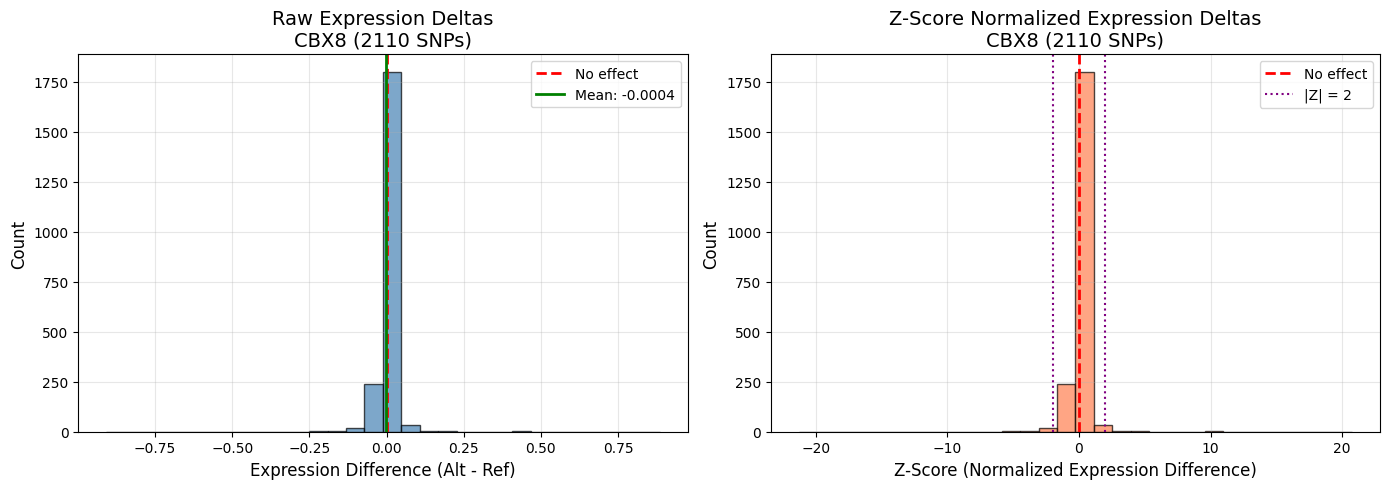


Summary Statistics:
  Raw diff - Mean: -0.000410, Std: 0.042630
  Raw diff - Min: -0.908849, Max: 0.885263
  |Z| > 2: 38 variants (1.8%)


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw differences
ax1 = axes[0]
valid_diff = SNP_annotations['diff'].dropna()
ax1.hist(valid_diff, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No effect')
ax1.axvline(x=valid_diff.mean(), color='green', linestyle='-', linewidth=2, label=f'Mean: {valid_diff.mean():.4f}')
ax1.set_xlabel('Expression Difference (Alt - Ref)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title(f'Raw Expression Deltas\n{GENE_NAME} ({len(valid_diff)} SNPs)', fontsize=14)
ax1.legend()
ax1.grid(alpha=0.3)

# Normalized differences
ax2 = axes[1]
valid_norm = SNP_annotations['normalized_diff'].dropna()
ax2.hist(valid_norm, bins=30, edgecolor='black', alpha=0.7, color='coral')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No effect')

# Add significance thresholds
ax2.axvline(x=-2, color='purple', linestyle=':', linewidth=1.5, label='|Z| = 2')
ax2.axvline(x=2, color='purple', linestyle=':', linewidth=1.5)
ax2.set_xlabel('Z-Score (Normalized Expression Difference)', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title(f'Z-Score Normalized Expression Deltas\n{GENE_NAME} ({len(valid_norm)} SNPs)', fontsize=14)
ax2.legend()
ax2.grid(alpha=0.3)
plt.tight_layout()
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
plt.savefig(OUTPUT_DIR / f'{GENE_NAME}_expression_delta_histograms.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\nSummary Statistics:")
print(f"  Raw diff - Mean: {valid_diff.mean():.6f}, Std: {valid_diff.std():.6f}")
print(f"  Raw diff - Min: {valid_diff.min():.6f}, Max: {valid_diff.max():.6f}")
print(f"  |Z| > 2: {(valid_norm.abs() > 2).sum()} variants ({100*(valid_norm.abs() > 2).mean():.1f}%)")


In [17]:
# Compare TSS-centered vs SNP-centered predictions (Only if both were run)
if not TSS_CENTERED_ONLY:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Reference expression comparison
    ax1 = axes[0]
    valid_mask = SNP_annotations['tss_ref_exp'].notna() & SNP_annotations['snp_ref_exp'].notna()
    
    if valid_mask.sum() > 0:
        ax1.scatter(
            SNP_annotations.loc[valid_mask, 'tss_ref_exp'],
            SNP_annotations.loc[valid_mask, 'snp_ref_exp'],
            alpha=0.6
        )

        # Add diagonal line
        lims = [
            min(ax1.get_xlim()[0], ax1.get_ylim()[0]),
            max(ax1.get_xlim()[1], ax1.get_ylim()[1])
        ]
        ax1.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
        ax1.set_xlabel('TSS-Centered Prediction', fontsize=12)
        ax1.set_ylabel('SNP-Centered Prediction', fontsize=12)
        ax1.set_title('Reference Allele Expression\n(TSS vs SNP centering)', fontsize=14)
        ax1.grid(alpha=0.3)

        # Difference comparison
        ax2 = axes[1]
        tss_diff = SNP_annotations['tss_alt_exp'] - SNP_annotations['tss_ref_exp']
        snp_diff = SNP_annotations['snp_alt_exp'] - SNP_annotations['snp_ref_exp']
        valid_mask = tss_diff.notna() & snp_diff.notna()
        ax2.scatter(tss_diff[valid_mask], snp_diff[valid_mask], alpha=0.6)
        lims = [
            min(ax2.get_xlim()[0], ax2.get_ylim()[0]),
            max(ax2.get_xlim()[1], ax2.get_ylim()[1])
        ]
        ax2.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
        ax2.set_xlabel('TSS-Centered Effect', fontsize=12)
        ax2.set_ylabel('SNP-Centered Effect', fontsize=12)
        ax2.set_title('Variant Effect (Alt-Ref)\n(TSS vs SNP centering)', fontsize=14)
        ax2.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / f'{GENE_NAME}_centering_comparison.png', dpi=150, bbox_inches='tight')
        plt.show()

        # Correlation
        if valid_mask.sum() > 2:
            corr = np.corrcoef(tss_diff[valid_mask], snp_diff[valid_mask])[0, 1]
            print(f"Correlation between TSS and SNP-centered effects: {corr:.4f}")
    else:
        print("No variants have valid predictions for both methods.")
else:
    print("Skipping comparison plot (TSS_CENTERED_ONLY is True)")

Skipping comparison plot (TSS_CENTERED_ONLY is True)


## 10. Export Results


In [18]:

# Export full results
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
output_file = OUTPUT_DIR / f"{GENE_NAME}_variant_effects.csv"
SNP_annotations.to_csv(output_file, index=False)
print(f"Results saved to: {output_file}")

# Display final summary
print(f"\n" + "="*60)
print(f"ANALYSIS COMPLETE")
print(f"="*60)
print(f"Gene: {GENE_NAME}")
print(f"Chromosome: {gene_info['chrom']}")
print(f"TSS: {gene_info['tss']:,}")
print(f"\nTask Filter: {TASK_FILTER}")
print(f"Number of tasks used: {len(task_indices)}")
print(f"\nModel replicates: {MODEL_REPLICATES}")
print(f"Centering strategies: TSS-centered, SNP-centered")
print(f"\nVariants analyzed: {len(SNP_annotations)}")
print(f"Variants with valid predictions: {SNP_annotations['diff'].notna().sum()}")
print(f"\nTop variants by |Z-score|:")
display_cols = ['rsID', 'chrom', 'position', 'ref_allele', 'alt_allele', 'diff', 'normalized_diff']
top_variants = SNP_annotations.nlargest(5, 'normalized_diff', keep='first')[display_cols]
print(top_variants.to_string())

Results saved to: /storage/work/mgc5166/Annotations/eQTL_annotations_for_susine/output/CBX8_variant_effects.csv

ANALYSIS COMPLETE
Gene: CBX8
Chromosome: chr17
TSS: 79,801,682

Task Filter: {'assay': 'rna', 'description': 'lung', 'name': 'gtex'}
Number of tasks used: 3

Model replicates: [0, 1, 2, 3]
Centering strategies: TSS-centered, SNP-centered

Variants analyzed: 2110
Variants with valid predictions: 2110

Top variants by |Z-score|:
                        rsID  chrom  position ref_allele alt_allele      diff  normalized_diff
952   chr17_79792822_G_A_b38  chr17  79792822          G          A  0.885263        20.775961
1046  chr17_79838055_G_A_b38  chr17  79838055          G          A  0.609192        14.299930
961   chr17_79796038_T_C_b38  chr17  79796038          T          C  0.466497        10.952632
957   chr17_79794855_C_A_b38  chr17  79794855          C          A  0.420196         9.866493
954   chr17_79793497_C_A_b38  chr17  79793497          C          A  0.198174      

## 11. Validation Summary


In [19]:
print("VALIDATION CHECKS SUMMARY")
print("="*60)

# Check 1: Reference allele matching
tss_ref_match = SNP_annotations['tss_ref_match'].dropna()
snp_ref_match = SNP_annotations['snp_ref_match'].dropna()
print(f"\n1. Reference Allele Matching:")
if len(tss_ref_match) > 0:
    print(f"   TSS-centered: {tss_ref_match.sum()}/{len(tss_ref_match)} matched ({100*tss_ref_match.mean():.1f}%)")
if len(snp_ref_match) > 0:
    print(f"   SNP-centered: {snp_ref_match.sum()}/{len(snp_ref_match)} matched ({100*snp_ref_match.mean():.1f}%)")

# Check 2: SNPs in editable region (TSS-centered)
print(f"\n2. SNPs in Editable Region (TSS-centered):")
n_valid_tss = SNP_annotations['tss_ref_exp'].notna().sum()
print(f"   {n_valid_tss}/{len(SNP_annotations)} variants ({100*n_valid_tss/len(SNP_annotations):.1f}%)")

# Check 3: Gene bins in output (TSS-centered)
print(f"\n3. Gene Bins in Output Field:")
is_valid, msg = validate_bins_in_output(gene_exon_bins_tss, N_OUTPUT_BINS)
status = "OK" if is_valid else "FAIL"
print(f"   {status} {msg}")

# Check 4: Missing predictions (detailed)
print(f"\n4. Missing Predictions:")
missing_mask = (SNP_annotations['tss_status'] != 'success') | (SNP_annotations['snp_status'] != 'success')
missing_variants = SNP_annotations[missing_mask]
print(f"   Total variants with any missing score: {len(missing_variants)}")
if len(missing_variants) > 0:
    print("   Detailed missing summaries:")
    for _, row in missing_variants.iterrows():
        missing_parts = []
        if row['tss_status'] != 'success':
            missing_parts.append(f"TSS ({row['tss_missing_reason']})")
        if row['snp_status'] != 'success':
            missing_parts.append(f"SNP ({row['snp_missing_reason']})")
        rel_pos = int(row['relative_to_tss'])
        missing_str = ', '.join(missing_parts)
        print(
            f"     - {row['rsID']} at {row['chrom']}:{row['position']} (offset {rel_pos:+} from TSS): "
            f"missing {missing_str}"
        )
else:
    print("   All variants have both TSS- and SNP-centered scores.")
print(f"\n" + "="*60)


VALIDATION CHECKS SUMMARY

1. Reference Allele Matching:
   TSS-centered: 2110/2110 matched (100.0%)

2. SNPs in Editable Region (TSS-centered):
   2110/2110 variants (100.0%)

3. Gene Bins in Output Field:
   OK All bins valid (range: 2773 - 3073, output size: 6144)

4. Missing Predictions:
   Total variants with any missing score: 2110
   Detailed missing summaries:
     - chr17_79540699_G_T_b38 at chr17:79540699 (offset -260983 from TSS): missing SNP (tss_only_mode)
     - chr17_79540864_C_G_b38 at chr17:79540864 (offset -260818 from TSS): missing SNP (tss_only_mode)
     - chr17_79541188_C_T_b38 at chr17:79541188 (offset -260494 from TSS): missing SNP (tss_only_mode)
     - chr17_79541336_A_G_b38 at chr17:79541336 (offset -260346 from TSS): missing SNP (tss_only_mode)
     - chr17_79541515_C_G_b38 at chr17:79541515 (offset -260167 from TSS): missing SNP (tss_only_mode)
     - chr17_79541910_G_A_b38 at chr17:79541910 (offset -259772 from TSS): missing SNP (tss_only_mode)
     - chr1